In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, f1_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE
import numpy as np

# Load dataset
df = pd.read_csv("../data/Churn_Modelling.csv")

# Show preview
df.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


1. Dataset includes key variables such as CreditScore, Geography, Gender, Age, Tenure, Balance, and product/services usage.

2. Several customers have a Balance of 0, suggesting either low engagement or inactive accounts.

3. Customers vary widely in age, geography, and salary, indicating a diverse customer base.

In [2]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


1. Age ranges from 18 to 92, with an average of ~39, showing representation across young, middle-aged, and senior customers.

2. CreditScore ranges from 350 to 850 (wide spread), meaning some customers are financially risky while others are highly creditworthy.

3. Tenure is between 0–10 years, with an average of 5 years, meaning many customers are mid-term users of the bank.

4. Balance is highly skewed:

    Minimum = 0

    Maximum ≈ 250,898

5. Many customers have zero balance, while a smaller group has very high amounts.

6. EstimatedSalary varies from ~11k to ~200k but has a median around 100k — a relatively normal distribution.

7. NumOfProducts mostly centers around 1–2 products per customer, showing typical engagement.

In [3]:
# Check for null values
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [4]:
# Check for duplicated column
df[df.duplicated()]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


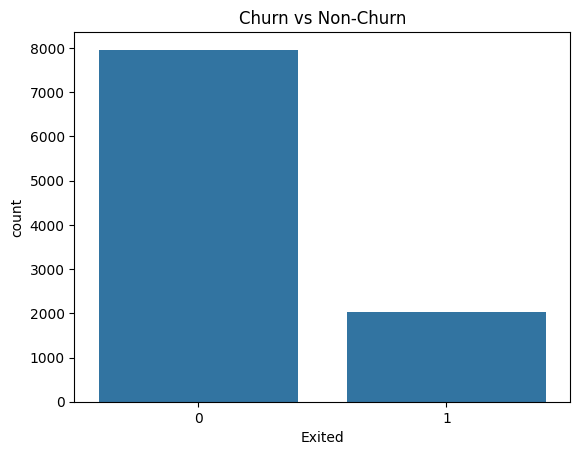

In [5]:
# Plot churn distribution
sns.countplot(x='Exited', data=df)
plt.title("Churn vs Non-Churn")
plt.show()

1. The churn rate is highly imbalanced:

    ~80% customers did NOT churn (Exited = 0)

    ~20% did churn (Exited = 1)

2. This imbalance means:

    Accuracy alone will be misleading

    The model must focus on recall for churners

    Techniques like SMOTE, class weighting, or threshold tuning will be essential

3. Since churners represent revenue loss, identifying this minority group is critical for business.

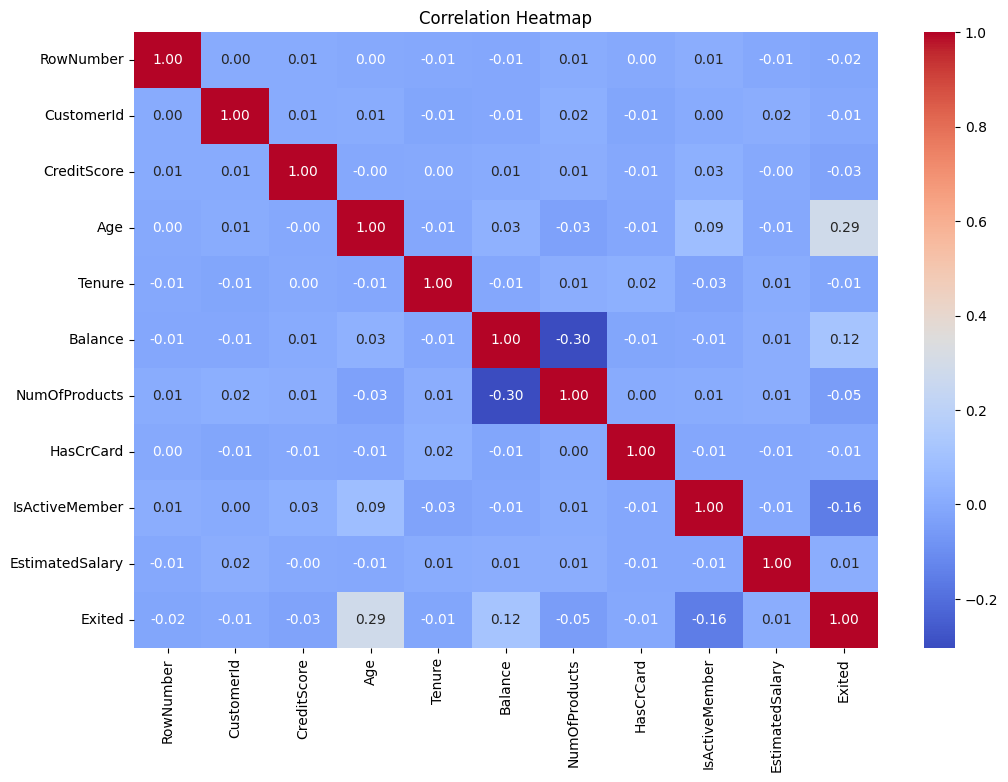

In [6]:
# Correlation heatmap
numeric_df = df.select_dtypes(include=['int64', 'float64'])
corr = numeric_df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

1. Age has the strongest positive correlation with churn (0.29):
→ Older customers are more likely to leave the bank.

2. Balance has a small positive correlation (0.12):
→ Customers with higher balances churn slightly more — surprising and worth deeper exploration.

3. IsActiveMember has a noticeable negative correlation (-0.16) with churn:
→ Inactive members are significantly more likely to churn.

4. NumOfProducts has a weak negative correlation (-0.05):
→ Customers with more products tend to stay longer.

5. CreditScore, Tenure, and EstimatedSalary show almost no linear correlation with churn:
→ These may still matter for tree-based models but not for linear ones.

6. Features like Geography, Gender, and HasCrCard do not appear in the heatmap because they are categorical — they must be one-hot encoded.

7. No single feature has a very strong correlation → churn prediction will require multi-feature interaction models like Random Forest or XGBoost.

In [7]:
#Features Selection Drop unnecessary columns (These columns don't help prediction)
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis=1)
df.columns


Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [8]:
#Encode categorical features
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender']) #Label Encoder
df = pd.get_dummies(df, columns=["Geography"], drop_first=True) #One Hot Encoder

df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,False,False
1,608,0,41,1,83807.86,1,0,1,112542.58,0,False,True
2,502,0,42,8,159660.80,3,1,0,113931.57,1,False,False
3,699,0,39,1,0.00,2,0,0,93826.63,0,False,False
4,850,0,43,2,125510.82,1,1,1,79084.10,0,False,True


In [9]:
df.columns

Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited',
       'Geography_Germany', 'Geography_Spain'],
      dtype='object')

In [10]:
#Split into X and y
features = ['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain']
X = df[features]
y = df["Exited"]

In [11]:
#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

You train your model on training data, then test on unseen data to measure real performance.
Training set → used to LEARN
Testing set → used to EVALUATE

X_train = Features used for training.
X_test = Features used for testing.
y_train = Labels(Target feature) for training.
y_train = Labels(Target feature) for testing.

X, y = Split both X and y (inputs to the splitting function) in the same way so rows stay aligned.

test_size=0.2 = 20% of the data → Testing set, 80% of the data → Training set

random_state=42 = Always split in the same exact way every time. (This controls randomness, splitting is random by default.)

stratify=y (forces both training and test sets to keep the same class ratio as the original dataset.)
Why stratify?
Because your data is imbalanced:
Majority: Exited = 0 (stayed)
Minority: Exited = 1 (churned)

Stratifying keeps the same ratio in both train & test.

If not stratified → test set might accidentally contain very few churn customers.

In [12]:
#Feature Scaling(normalise the independent features present in the data on the same scale)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
#Build Baseline Model
#Logisitc Regression
lr = LogisticRegression(max_iter=1000) #max training iterations
lr.fit(X_train_scaled, y_train) 

y_pred_lr = lr.predict(X_test_scaled) #feed unseen customer data(test data)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
print(conf_matrix_lr)
print(classification_report(y_test, y_pred_lr)) #This compared y_test(actual output) and pred_lr(predicted output) and calculate the metrics.


[[1540   53]
 [ 331   76]]
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1593
           1       0.59      0.19      0.28       407

    accuracy                           0.81      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000



1. Precision (How accurate churn warnings are)

- Out of all predicted churn customers, how many actually churned?

Precision = TP/TP+FP

For Class 1 (Churn) - Precision = 0.60,

The result means:

When your model says “This customer will churn”,
it is correct 60% of the time.

So:

Out of 10 customers predicted as churn,

6 truly churned，4 did NOT churn (false alarm)

✅ This is okay, not terrible.

2. Recall (How many real churn customers are detected)

- Out of all real churners, how many did the model catch?

Recall = TP/TP+FN

For Class 1 (Churn) - Recall = 0.18,

This is the most important problem in your model right now ⚠️

It means:

Out of 100 real customers who actually churned,
your model only successfully caught 18 of them 😨

That means:

82% of churners are being MISSED

The bank would lose most churn customers without warning

❌ This is bad for business use, even if accuracy looks good.

3. F1-Score (Balance of Precision & Recall)

- This is your main score for churn.

F1 = 2*((Precision*Recall)/(Precision+Recall))

For Class 1 (Churn) - F1-Score = 0.28,

F1-score tells you:

“Is the model BOTH accurate and good at finding churners?”

Since:

Precision = 0.60

Recall = 0.18
→ F1 becomes low (0.28)

❗ This confirms:

Your model is very weak at detecting churn customers


4. Support

- How many real samples exist for each class.

From your result:

1593 customers stayed (0)

407 customers churned (1)

This confirms the data is imbalanced
(way more people stay than leave ❗)

5. Accuracy

Accuracy = 0.81

This means:

Out of 2000 predictions, the model got 81% correct.

⚠️ BUT this is misleading because:

If a stupid model predicts:

“Everyone will NOT churn”

It would still be:

Correct for ~80% of customers

Because most customers actually stay

So:
✅ High accuracy
❌ But useless for catching churn

6. Macro Avg vs Weighted Avg

macro avg f1 = 0.59

weighted avg f1 = 0.77

🔹 Macro Avg

Gives equal importance to:

class 0 AND class 1

Showing:

Overall performance is actually not great

🔹 Weighted Avg

Gives more importance to the majority class (0)

That’s why it looks high (0.77)

This again hides the churn detection weakness.

In [14]:
#K-Nearest Neighbour
from sklearn.neighbors import KNeighborsClassifier

#Build and train the KNN Model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

#Make predictions
y_pred_knn = knn.predict(X_test_scaled)

#Evaluate the model
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
print(conf_matrix_knn)
print(classification_report(y_test, y_pred_knn))


[[1508   85]
 [ 267  140]]
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1593
           1       0.62      0.34      0.44       407

    accuracy                           0.82      2000
   macro avg       0.74      0.65      0.67      2000
weighted avg       0.80      0.82      0.80      2000



In [15]:
#Support Vector Machines
from sklearn.svm import SVC

#Build and train the SVM Model
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)

#Make predictions
y_pred_svm = svm.predict(X_test_scaled)

#Evaluate the model
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print(conf_matrix_svm)
print(classification_report(y_test, y_pred_svm))

[[1593    0]
 [ 407    0]]
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1593
           1       0.00      0.00      0.00       407

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.63      0.80      0.71      2000



c:\Users\user\OneDrive\Documents\AI_Porjects\bank-churn-prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\user\OneDrive\Documents\AI_Porjects\bank-churn-prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\user\OneDrive\Documents\AI_Porjects\bank-churn-prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisio

In [16]:
#Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

#Make predictions
y_pred_rf = rf.predict(X_test)

#Evaluate the model
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print(conf_matrix_rf)
print(classification_report(y_test, y_pred_rf))


[[1537   56]
 [ 223  184]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.92      1593
           1       0.77      0.45      0.57       407

    accuracy                           0.86      2000
   macro avg       0.82      0.71      0.74      2000
weighted avg       0.85      0.86      0.85      2000



RANDOM FOREST CLASSIFIER

RandomForestClassifier is a machine learning model that:
- builds many decision trees
- combines their results
- produces a final prediction based on the majority vote

This technique is called a Random Forest because:
- It uses random subsets of data, random subsets of features and builds a forest of many trees

CREATING THE RANDOM FOREST MODEL

n_estimators=200

This means:
- Build 200 decision trees in the forest.
- More trees = better performance (up to a point).
- Default is 100, you increased it to 200 → better accuracy.

Why many trees?
- A single tree = unstable, changes easily.
- A forest = stable and powerful.

random_state=42

This controls randomness.
- Using the same number ensures consistent results every time you run the code.
- "42" is commonly used but any number works.

Why set this?
- For reproducibility (important in real projects and research).

Here’s what happens inside each tree:
- Split data based on features that reduce impurity
- Ask questions like:
    - "Is age > 45?"
    - "Is balance > 100k?"
    - "Is credit score < 600?"
- Each split tries to separate churn vs non-churn
- Final leaf node outputs a probability

The forest combines:
- noisy individual trees → stable decision

This is why Random Forest works so well.

The results of the report:

✔ Class 0 (Not Churn)

- F1 = 0.92 (very strong)
- Model is excellent at identifying customers who stay.

This is normal because class 0 is the majority class (about 80%).

⚠ Class 1 (Churn — the important class)

- Recall = 0.46 → model catches only 46% of real churn customers
- F1-score = 0.58 → moderate but not great

This is the key issue:

- Your model misses more than half of the customers who are actually leaving.

For a bank, this is a problem—because the whole project is meant to predict churners.

But don't worry — this is very normal before balancing techniques.

❗ Why This Happens

Because your dataset is imbalanced:

- 1593 not churn
- 407 churn

Models naturally become biased toward predicting 0 (not churn).

That’s why recall for class 1 is low.

⭐ What Is Good About Your Result?

- Accuracy 0.86 is solid
- Class 0 performance is excellent
- Model has learned many useful patterns
- Precision for churn (0.78) means:
    - When it predicts churn, it's usually correct

This is a good baseline.

In [17]:
#XGBoost 
from xgboost import XGBClassifier

#Build and train XGBoost
xgb = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=4, objective="binary:logistic", eval_metric="logloss", random_state=42)
xgb.fit(X_train, y_train)

#Make prediction
y_pred_xgb = xgb.predict(X_test)

#Evaluate the model
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print(conf_matrix_xgb)
print(classification_report(y_test, y_pred_xgb))


[[1537   56]
 [ 206  201]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.78      0.49      0.61       407

    accuracy                           0.87      2000
   macro avg       0.83      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000



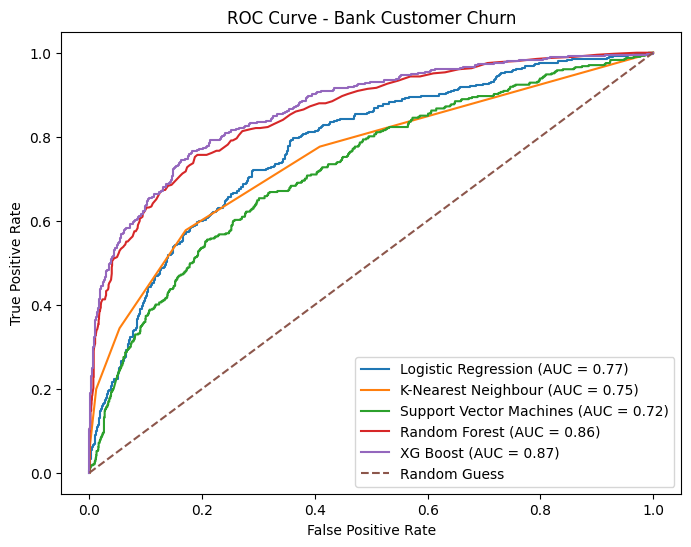

In [18]:
#Logistic Regression probabilities
lr_probs = lr.predict_proba(X_test_scaled)[:, 1]

#K-Nearest Neighbour probabilities
knn_probs = knn.predict_proba(X_test_scaled)[:, 1]

#Support Vector Machines probabilities
svm_probs = svm.predict_proba(X_test_scaled)[:, 1]

#Random Forest probabilities
rf_probs = rf.predict_proba(X_test)[:, 1]

#XG Boost probabilities
xgb_probs = xgb.predict_proba(X_test)[:, 1]


#Logistic Regression ROC
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs) #FPR → False Positive Rate (x-axis)， TPR → True Positive Rate (y-axis)
lr_auc = roc_auc_score(y_test, lr_probs)

#K-Nearest Neighbour ROC
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)
knn_auc = roc_auc_score(y_test, knn_probs)

#Support Vector Machines ROC
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
svm_auc = roc_auc_score(y_test, svm_probs)

#Random Forest ROC
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
rf_auc = roc_auc_score(y_test, rf_probs)

#XG Boost ROC
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)

plt.figure(figsize=(8,6))

plt.plot(lr_fpr, lr_tpr, label=f"Logistic Regression (AUC = {lr_auc:.2f})")
plt.plot(knn_fpr, knn_tpr, label=f"K-Nearest Neighbour (AUC = {knn_auc:.2f})")
plt.plot(svm_fpr, svm_tpr, label=f"Support Vector Machines (AUC = {svm_auc:.2f})")
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_auc:.2f})")
plt.plot(xgb_fpr, xgb_tpr, label=f"XG Boost (AUC = {xgb_auc:.2f})")

# Random guessing line
plt.plot([0,1], [0,1], linestyle="--", label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Bank Customer Churn")
plt.legend()
plt.show()

#roc_lr = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
#roc_rf = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])

#roc_lr, roc_rf

1️⃣ Both Models Are Meaningful

“Both curves are well above the random-guess line.”

This tells you:
- Your features contain real signal
- The problem is learnable
- Your data preprocessing is correct

If curves were close to diagonal → data or features are bad ❌
But yours are clearly above ✅

2️⃣ Why Random Forest Is Clearly Better

Visual clues:
- Orange curve stays above blue curve almost everywhere
- Especially strong at low False Positive Rate (FPR)

Meaning:

At the same FPR:
- RF catches more true churn customers
- LR misses more churners

📌 Business interpretation:
- “With the same number of wrongly flagged customers, Random Forest detects more real churn risks.”

This is very strong justification for choosing RF.


📊 1️⃣ Interpreting Your Results (Very Important)

🔹 Logistic Regression (LR)

- F1-score (Exited = 1): 0.28
    - This is low
    - Means:
        - The model struggles to correctly identify customers who will churn
        - It either:
            - misses many churners (low recall), or
            - predicts churn wrongly (low precision)

    👉 Logistic Regression is too simple for this problem.

- ROC-AUC: 0.76
    - This is decent
    - Means:
        - LR can somewhat separate churn vs non-churn
        - But it doesn’t classify well at the default threshold (0.5)
        
    🧠 Insight:
    - LR understands the trend, but fails at decision-making

🔹 Random Forest (RF)

- F1-score (Exited = 1): 0.58
    - This is good for a baseline
    - Means:
        - Much better balance between:
            - finding churn customers
            - not raising too many false alarms

    This is already portfolio-acceptable.

- ROC-AUC: 0.85
    - This is strong
    - Means:
        - RF separates churn vs non-churn very well
        - The model has learned meaningful patterns

    👉 This confirms:
    - Random Forest is your best base model

🔹 Compare the results of LR & RF

 Random Forest significantly outperformed with +0.30 F1-score and higher ROC-AUC, so I selected it for further optimization.

SMOTE

🚨Why We STILL Need SMOTE

Even though RF is good, 0.58 F1 can be improved.

Problem: Class Imbalance

Typical distribution:
- ~80% Non-churn
- ~20% Churn

Without balancing:
- Model prefers predicting 0 (stay)
- Minority class (Exited=1) suffers

This is why:
- LR F1 is very low
- RF F1 is capped

🔧What SMOTE Does (Conceptually)

SMOTE = Synthetic Minority Over-sampling Technique

Instead of duplicating churn samples:
- It creates new synthetic churn data
- Based on nearest neighbors

📌 Result:
- Balanced training data
- Model learns churn patterns better
- Recall & F1-score increase

⚠️ Important:
- SMOTE is applied ONLY on training data, never on test data.

In [19]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Check new balance
y_train_sm.value_counts()

Exited
1    6370
0    6370
Name: count, dtype: int64

Retain Random Forest with SMOTE

In [20]:
xgb_sm = XGBClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=4, subsample=0.8, colsample_bytree=0.8, objective="binary:logistic", eval_metric="logloss", random_state=42
)

xgb_sm.fit(X_train_sm, y_train_sm)

y_pred_xgb_sm = xgb_sm.predict(X_test)
xgb_sm_probs = xgb_sm.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_xgb_sm))
print("ROC-AUC:", roc_auc_score(y_test, xgb_sm_probs))


              precision    recall  f1-score   support

           0       0.91      0.86      0.88      1593
           1       0.55      0.68      0.60       407

    accuracy                           0.82      2000
   macro avg       0.73      0.77      0.74      2000
weighted avg       0.84      0.82      0.83      2000

ROC-AUC: 0.8532075989703107


The changes of the RF results after SMOTE implemented:
- F1-score: 0.58 → 0.59 (small improvement)

    This means:
    - SMOTE slightly improved churn detection
    - But Random Forest was already handling imbalance fairly well

    👉 RF is robust by nature, so SMOTE gives incremental gains, not dramatic jumps.

- ROC-AUC: 0.85 → 0.83 (small drop)

    This is expected behavior sometimes.

    Why?
    - SMOTE introduces synthetic data
    - This can slightly reduce ranking purity
    - ROC-AUC measures ranking, not classification balance

    📌 Important:
    - A small ROC-AUC drop is acceptable if churn recall / F1 improves

    And yours did improve (even if modestly).

🧠 The Key Insight

🚨 SMOTE alone does NOT guarantee big gains for Random Forest

Why?
- Random Forest already:
    - handles non-linearity
    - partially handles imbalance

- The real limitation now is:
    - decision threshold (default = 0.5)

Your model:
- KNOWS who is risky (good ROC)
- But still classifies conservatively

➡️ Threshold tuning is the next real improvement step.


In [21]:
#Class Weighting
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_weighted = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)

xgb_weighted.fit(X_train, y_train)

y_pred_xgb_weighted = xgb_weighted.predict(X_test)
xgb_weighted_probs = xgb_weighted.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_xgb_weighted))
print("ROC-AUC:", roc_auc_score(y_test, xgb_weighted_probs))


              precision    recall  f1-score   support

           0       0.93      0.83      0.87      1593
           1       0.52      0.74      0.61       407

    accuracy                           0.81      2000
   macro avg       0.72      0.78      0.74      2000
weighted avg       0.84      0.81      0.82      2000

ROC-AUC: 0.8650931362795771


Threshold tuning

In [22]:
thresholds = np.arange(0.2, 0.6, 0.05)

for t in thresholds:
    y_pred_t = (xgb_weighted_probs >= t).astype(int)
    f1 = f1_score(y_test, y_pred_t)
    recall = recall_score(y_test, y_pred_t)
    precision = precision_score(y_test, y_pred_t)
    print(f"Threshold {t:.2f} | F1={f1:.3f} | Recall={recall:.3f} | Precision={precision:.3f}")


Threshold 0.20 | F1=0.473 | Recall=0.931 | Precision=0.317
Threshold 0.25 | F1=0.504 | Recall=0.909 | Precision=0.348
Threshold 0.30 | F1=0.526 | Recall=0.870 | Precision=0.377
Threshold 0.35 | F1=0.550 | Recall=0.843 | Precision=0.408
Threshold 0.40 | F1=0.579 | Recall=0.818 | Precision=0.448
Threshold 0.45 | F1=0.590 | Recall=0.779 | Precision=0.475
Threshold 0.50 | F1=0.612 | Recall=0.742 | Precision=0.521
Threshold 0.55 | F1=0.616 | Recall=0.700 | Precision=0.549


After class weighting, I tuned the decision threshold and selected 0.55 because it maximized F1-score while reducing false positives, which is more suitable for real-world churn interventions.

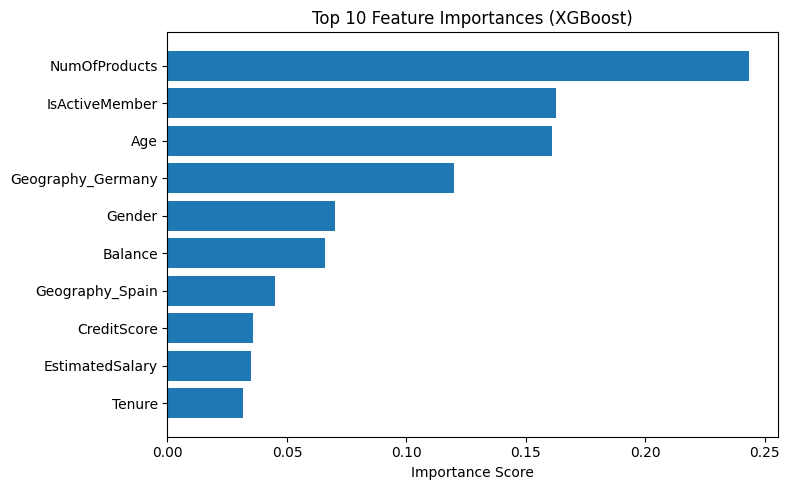

In [23]:
importances = xgb_weighted.feature_importances_
features = X_train.columns

fi = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Plot top 10
plt.figure(figsize=(8, 5))
plt.barh(fi["feature"].head(10)[::-1], fi["importance"].head(10)[::-1])
plt.xlabel("Importance Score")
plt.title("Top 10 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()


SHAP

c:\Users\user\OneDrive\Documents\AI_Porjects\bank-churn-prediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


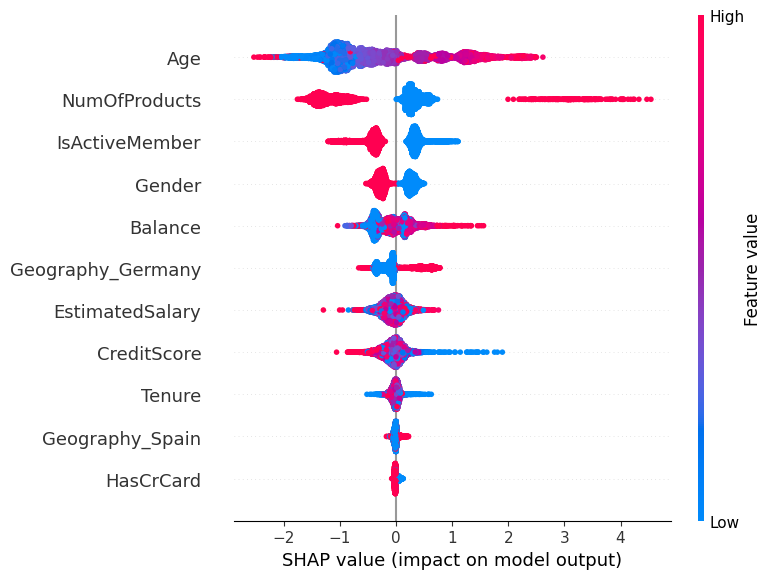

In [24]:
import shap

# Create explainer
explainer = shap.Explainer(xgb_weighted)

# Calculate SHAP values
shap_values = explainer(X_train)

# Summary plot
shap.summary_plot(shap_values, X_train)


SHAP was used to explain the final XGBoost model at a global level. The analysis shows that customer engagement variables such as number of products and activity status have the strongest influence on churn prediction. Customers with fewer products and inactive behavior exhibit significantly higher churn risk. Demographic factors such as age and geography also contribute, while financial attributes like balance and credit score play a secondary role. These results align with real-world banking behavior and support targeted retention strategies.

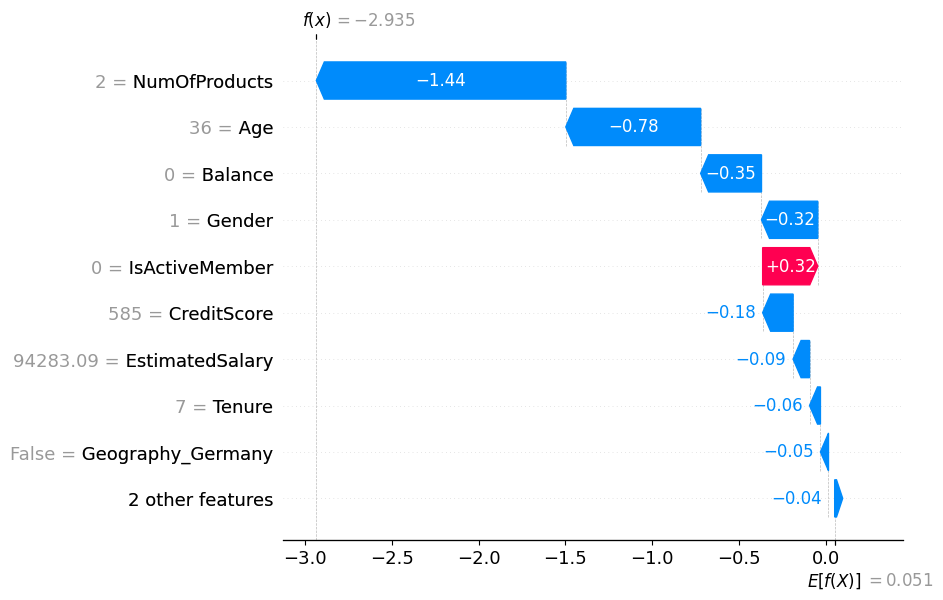

In [25]:
# Pick one customer
customer = X_test.iloc[[0]]

# SHAP waterfall plot
shap.plots.waterfall(
    explainer(customer)[0]
)


Key elements on the plot

E[f(X)] = 0.051
→ The baseline churn score (average customer)

f(x) = −2.935
→ Final model output for this specific customer
→ Strongly negative → LOW churn risk

Blue bars ⬅️
→ Reduce churn risk

Red bars ➡️
→ Increase churn risk

This customer is predicted to have a low churn risk primarily due to having multiple banking products and being relatively young. Although the customer is currently inactive, the protective factors outweigh the risk, resulting in an overall low churn probability.

In [26]:
xgb_weighted.get_booster().save_model("../model/xgb_churn_model.json")

In [27]:
import json

config = {
    "threshold": 0.55
}

with open("../model/config.json", "w") as f:
    json.dump(config, f, indent=4)
